


<h1><center><span style="color:#C2571A"> Prediction of daily changes of rates for hotel rooms </span></center></h1>

## 1. Project motivation

Rate shopping of hotel room rates has computational and monetary cost, yet it is important to have up-to-date information about hotel room rates.

The goal of this project is to test if it’s possible to predict if at a specific day there will be a change in rates for a hotel room using parameters of hotels/rooms and history of rates changes from the past.

The result of this project is a predictive model of hotel room rates changes. Results of this project can be used as a proof of the concept.

##  2. The Dataset

The dataset used in this project contains historical data of rate shopping for the period from 2020-10-29 to 2021-02-24 of hotel rates from web-site providing on-line registration services for different types of accommodation. 

Hotels from our dataset are located in Lisbon, London and Barcelona.
During one rate shopping iteration we get updated rates for each hotel room available for the stay dates for 1 year (365 days) ahead, so one observation is the rate for the room for the given `stay_date`. 

On average there are two rate shopping iteration per day of rates for each room for 365 days of `stay_date`.

Columns in the Dataset:
-  updated_at: object - timestamp of update 
-  stay_date: object - date of stay in hotel room 
- room_id: object 
- rate_current: int64 - rate updated
- rate_old: int64  - rate before update
- cancellaption_policy_current: object 
- cancellation_policy_old: object 
- room_max_occupancy: int64  
- room_name: object 
- hotel_id: object 
- hotel_name: object 
- hotel_city: object 
- hotel_country: object 
- hotel_rating: int64  
- hotel_currency: object 
- hotel_total_room_count: int64  
- min_len_of_stay: int64  
- hotel_longitude: float64
- hotel_latitude: float64    

## 3. Analysis Plan 

The task to be solved in this project is supervised binary classification problem. With the help of a predictive model we will be answering the question: "Will there be at least one change in rates for the whole period (365 days starting from today) for the given hotel room at a specific day (for example, tomorrow)?"

To implement predictive model following steps are to be performed:
- Read the dataset and transform the data:
    - Read the data.
    - Convert columns with dates as datetime and extract datetime features (number of day, week, month, year, week day, etc).
    - Encode binary target variable: `True` if there is at least one change in rates for the room and `False` if rates are not changed.
    - Group the data per update day per room: reflect if there is a change in rates for room for each day.
    - Add feature reflecting distance of hotel to the city center.
- Conduct exploratory data analysis.
- Generate features of history of rate changes (lag features).
- Predict if the rate changes for each day of the next week.
- Summarize the results and outline next steps.

## 4. Performance Metrics

To evaluate performance of the model following metrics will be used:

**Accuracy.** Accuracy is the proportion of true results among the total number of cases examined. This metric is nor robust for class imbalance data, so we will need to keep this in mind. Checking overall accuracy can be useful to evaluate general model performance.

**Recall.** This metric answers the following question: what proportion of actual Positives is correctly classified? This metric is one of the most important for this project as it's important to update all changed rates so we want to capture as many positives as possible.

**Precision.** This metric answers the following question: what proportion of predicted Positives is truly Positive? This metric is important as we want to reduce the number of rates shopping iterations, so we want to update all changed rates, but also to reduce the number of updates through rate shopping.

**AUC: area under the ROC curve.** AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes. We can use it to evaluate general model performance, but it's important to remember that this metric is sensitive to class imbalance. 

## 5. Read the dataset and transform the data

### 5.1 Read the data and check descriptive statistics

In [146]:
# Import libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, roc_auc_score

In [147]:
data1 = pd.read_csv('lisbon.csv')
data0 = pd.read_csv('london.csv')
data2 = pd.read_csv('barcelona.csv')

In [148]:
data=data0.append(data1).append(data2)

In [149]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6768194 entries, 0 to 1058675
Data columns (total 19 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   updated_at                    object 
 1   stay_date                     object 
 2   room_id                       object 
 3   rate_current                  int64  
 4   rate_old                      int64  
 5   cancellaption_policy_current  object 
 6   cancellation_policy_old       object 
 7   room_max_occupancy            int64  
 8   room_name                     object 
 9   hotel_id                      object 
 10  hotel_name                    object 
 11  hotel_city                    object 
 12  hotel_country                 object 
 13  hotel_rating                  int64  
 14  hotel_currency                object 
 15  hotel_total_room_count        int64  
 16  min_len_of_stay               int64  
 17  hotel_longitude               float64
 18  hotel_latitude        

None

In [150]:
# Drop columns with single unique value as they will not be useful for modeling and names of hotels/rooms 
data.drop(columns=['hotel_country', 'room_name', 'hotel_name'], inplace=True)

For now it's decided to drop 'room_name'/'hotel_name', but it’s possible that we can to extract useful information from these columns. For example, word ‘Economy’ in the name of the room can be a useful feature that has an affect a pattern of rate changes. 

### 5.2  Convert columns with dates as datetime and extract datetime features. Encode target variable.

In [151]:
# Convert columns to datatime
data['updated_at'] = pd.to_datetime(data['updated_at'])
data['stay_date'] = pd.to_datetime(data['stay_date'])

In [152]:
# Add consequent number of the update day
data['update_num'] = data.updated_at - pd.to_datetime("2020-10-29").tz_localize('UTC')
data['update_num'] = data['update_num'].dt.days

In [153]:
# Extract descriptive parameters of the update date
data.sort_values('updated_at', inplace=True)    
data['update_hour'] = data['updated_at'].dt.hour
data['update_day'] = data['updated_at'].dt.day
data['update_month'] = data['updated_at'].dt.month
data['update_year'] = data['updated_at'].dt.year
data['update_dweek'] = data['updated_at'].dt.weekday
data['update_numweek'] = [i.isocalendar()[1] for i in data['updated_at']]
data['update_weekend'] = [1 if (i==5)|(i==6) else 0 for i in data.update_dweek ]

In [154]:
# Calculate a difference between the update date and stay date for the booking
data['update_stay_date_diff'] = data.stay_date.dt.tz_localize('UTC') - data.updated_at + pd.Timedelta('1 days 00:00:00')
data['update_stay_date_diff'] = data['update_stay_date_diff'].dt.days

In [155]:
# Create binary target variable which indicates if there were changes in rates for each row (0 = 'no changes', 1 -'chaged rate')
data['target'] = data.rate_current != data.rate_old

In [156]:
# We will not use these features in the modeling but it can be useful for analyzing the data

# Extract descriptive parameters of the stay date 
data['stay_date_day'] = data['stay_date'].dt.day
data['stay_date_month'] = data['stay_date'].dt.month
data['stay_date_year'] = data['stay_date'].dt.year
data['stay_date_dweek'] = data['stay_date'].dt.weekday
data['stay_weekend'] = [1 if (i==5)|(i==6) else 0 for i in data.stay_date_dweek]

# Calculate the difference in rates
data['rate_diff'] = data.rate_current - data.rate_old 
data['rate_diff_%'] = (data.rate_diff)/data.rate_old

In [157]:
# Encode categorical features with Label Encoder

cancellation_policy_label = LabelEncoder()
data['cancellation_policy_old']  = cancellation_policy_label.fit_transform(data.cancellation_policy_old)

room_id_label = LabelEncoder()
data['room_id'] = room_id_label.fit_transform(data.room_id)

hotel_id_label = LabelEncoder()
data['hotel_id']  = hotel_id_label.fit_transform(data.hotel_id)

### 5.3 Group the data per day per room: reflect if there is a change in rates for room for update day

In [225]:
# Group the data
grouped = data.groupby([ 'hotel_id', 'room_id', 'hotel_city', 'hotel_currency',
       'update_day', 'update_month', 'update_year',
       'update_num', 'hotel_longitude', 'hotel_latitude',
       'update_dweek', 'update_weekend', 'update_numweek']).agg(
            {'target': [max, np.mean],
             'rate_old': 'first',
             'cancellation_policy_old': 'first', 
             'room_max_occupancy': 'first',
            'hotel_rating': 'first',
             'hotel_total_room_count': 'first',
             'min_len_of_stay': 'first'
            })

In [226]:
# Rest index to get flat dataset
grouped = pd.DataFrame(grouped).reset_index()
grouped = grouped.T.reset_index(drop=True).T

In [227]:
# Add column names for transformed dataset
grouped.columns = ['hotel_id', 'room_id', 'hotel_city', 'hotel_currency',
       'update_day', 'update_month', 'update_year',
       'update_num', 'hotel_longitude', 'hotel_latitude',
       'update_dweek', 'update_weekend', 'update_numweek', 'target', 'change_rate',
             'rate_old',
             'cancellation_policy_old', 
             'room_max_occupancy',
            'hotel_rating',
             'hotel_total_room_count',
             'min_len_of_stay']

In [228]:
# View first 5 rows of the grouped data 
display(grouped.head())

,hotel_id,room_id,hotel_city,hotel_currency,update_day,update_month,update_year,update_num,hotel_longitude,hotel_latitude,...,update_weekend,update_numweek,target,change_rate,rate_old,cancellation_policy_old,room_max_occupancy,hotel_rating,hotel_total_room_count,min_len_of_stay
0,0,113,Barcelona,EUR,2,2,2021,96,2.14742,41.4338,...,0,5,True,0.0680628,17791,0,4,4,156,1
1,0,113,Barcelona,EUR,3,2,2021,97,2.14742,41.4338,...,0,5,True,0.0229885,11881,0,4,4,156,1
2,0,113,Barcelona,EUR,4,2,2021,98,2.14742,41.4338,...,0,5,True,0.0557103,11881,0,4,4,156,1
3,0,113,Barcelona,EUR,5,2,2021,99,2.14742,41.4338,...,0,5,True,0.0597826,11881,0,4,4,156,1
4,0,113,Barcelona,EUR,6,1,2021,69,2.14742,41.4338,...,0,1,True,0.256055,17791,0,4,4,156,1


In [229]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22205 entries, 0 to 22204
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   hotel_id                 22205 non-null  object
 1   room_id                  22205 non-null  object
 2   hotel_city               22205 non-null  object
 3   hotel_currency           22205 non-null  object
 4   update_day               22205 non-null  object
 5   update_month             22205 non-null  object
 6   update_year              22205 non-null  object
 7   update_num               22205 non-null  object
 8   hotel_longitude          22205 non-null  object
 9   hotel_latitude           22205 non-null  object
 10  update_dweek             22205 non-null  object
 11  update_weekend           22205 non-null  object
 12  update_numweek           22205 non-null  object
 13  target                   22205 non-null  object
 14  change_rate              22205 non-nul

###  5.4 Add feature `distance_to_center`

We will use `hotel_longitude` and `hotel_latitude` features to calculate distance of hotels to the city center.

In [230]:
def haversine_distance(x):
    lat1 = x[0] 
    lon1 = x[1]
    lat2 = x[2] 
    lon2 = x[3] 
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [231]:
def distance_to_center(city, center_latitude, center_longitude, grouped = grouped):
    grouped.loc[grouped.hotel_city==city, 'center_latitude'] = center_latitude 
    grouped.loc[grouped.hotel_city==city, 'center_longitude'] = center_longitude
    grouped.loc[grouped.hotel_city==city, 'distance_to_center'] = grouped[grouped.hotel_city==city][['hotel_latitude', 'hotel_longitude', 'center_latitude', 'center_longitude']].apply(haversine_distance, axis=1)

In [232]:
distance_to_center(city='Barcelona', center_latitude=41.403030, center_longitude=2.187961)
distance_to_center(city = 'London', center_latitude=51.508303, center_longitude=-0.127398)
distance_to_center(city='Lisbon', center_latitude=38.722267, center_longitude=-9.139397)

In [233]:
grouped = grouped.drop(columns=['hotel_longitude', 'hotel_latitude'])
grouped = grouped.drop(columns=['center_latitude', 'center_longitude'])

In [234]:
grouped.head()

,hotel_id,room_id,hotel_city,hotel_currency,update_day,update_month,update_year,update_num,update_dweek,update_weekend,update_numweek,target,change_rate,rate_old,cancellation_policy_old,room_max_occupancy,hotel_rating,hotel_total_room_count,min_len_of_stay,distance_to_center
0,0,113,Barcelona,EUR,2,2,2021,96,1,0,5,True,0.0680628,17791,0,4,4,156,1,4.81
1,0,113,Barcelona,EUR,3,2,2021,97,2,0,5,True,0.0229885,11881,0,4,4,156,1,4.81
2,0,113,Barcelona,EUR,4,2,2021,98,3,0,5,True,0.0557103,11881,0,4,4,156,1,4.81
3,0,113,Barcelona,EUR,5,2,2021,99,4,0,5,True,0.0597826,11881,0,4,4,156,1,4.81
4,0,113,Barcelona,EUR,6,1,2021,69,2,0,1,True,0.256055,17791,0,4,4,156,1,4.81


## 6. Exploratory data analysis  

### 6.1 Feature `rate_old`

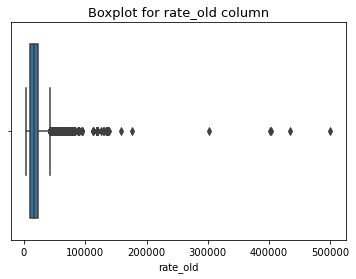

In [168]:
f= sns.boxplot(x = 'rate_old', data=grouped)
f.set_title('Boxplot for rate_old column', fontsize=13)
plt.show()

Some observations have very high rate (more than 300 000). I checked them, they all are related to the same hotel in Lisbon and values seem not to be correct as rate jumps from 10-20K to 400K.  It was decided to replace such high values with the 95  percentile for rates for these rooms. 

In [235]:
room_ids = grouped[grouped.rate_old>300000].room_id.unique()
for i in room_ids:
    percentile_95 = np.percentile(grouped[grouped.room_id==i].rate_old, 98)
    grouped.loc[(grouped.rate_old>300000)&(grouped.room_id==i), 'rate_old'] = percentile_95

In [236]:
for i in grouped.hotel_city.unique():
    df = grouped[grouped.hotel_city==i]
    cut_bins = [-1, np.percentile(data.rate_old,25), np.percentile(data.rate_old,50), 
                np.percentile(data.rate_old,75), np.percentile(data.rate_old,100)]
    grouped.loc[grouped.hotel_city==i, 'price_category'] = pd.cut(grouped.rate_old, bins=cut_bins, 
                                 labels=["0", "1", "2", "3"])
grouped['price_category'] = grouped.price_category.astype('int')

In [237]:
city_label = LabelEncoder()
grouped['hotel_city']  = city_label.fit_transform(grouped.hotel_city)              

currency_label = LabelEncoder()
grouped['hotel_currency']  = currency_label.fit_transform(grouped.hotel_currency)     

grouped = grouped.astype(float)

### 6.2 Explore `rate_diff_%` variation (average change in price)

In [238]:
# There are 12 records with rates changed to more than 4 times expensive ones. We will assume that these rates are valid.
display(data[data['rate_diff_%']>4])

,updated_at,stay_date,room_id,rate_current,rate_old,cancellaption_policy_current,cancellation_policy_old,room_max_occupancy,hotel_id,hotel_city,...,update_weekend,update_stay_date_diff,target,stay_date_day,stay_date_month,stay_date_year,stay_date_dweek,stay_weekend,rate_diff,rate_diff_%
429354,2020-11-03 17:38:45.152734+00:00,2020-12-07,3,49400,5900,FREE_CANCELLATION,0,2,30,London,...,0,34,True,7,12,2020,0,0,43500,7.372881
1407636,2020-11-05 17:03:09.999026+00:00,2020-11-07,132,40090,4275,FREE_CANCELLATION,0,1,74,London,...,0,2,True,7,11,2020,5,1,35815,8.377778
1375412,2020-11-16 16:46:45.602213+00:00,2020-12-11,132,44900,5700,FREE_CANCELLATION,0,1,74,London,...,0,25,True,11,12,2020,4,0,39200,6.877193
547430,2020-12-28 16:02:22.140572+00:00,2020-12-28,23,48840,7900,NON_REFUNDABLE,1,4,41,London,...,0,0,True,28,12,2020,0,0,40940,5.182278
552766,2020-12-28 16:02:22.140572+00:00,2020-12-29,23,48840,6600,NON_REFUNDABLE,0,4,41,London,...,0,1,True,29,12,2020,1,0,42240,6.400000
1994270,2021-02-13 17:34:51.769925+00:00,2021-03-09,199,65100,9000,FREE_CANCELLATION,0,2,81,London,...,1,24,True,9,3,2021,1,0,56100,6.233333
1418915,2021-02-22 18:42:46.143363+00:00,2021-03-27,233,43040,6980,FREE_CANCELLATION,0,2,35,Lisbon,...,0,33,True,27,3,2021,5,1,36060,5.166189
1417723,2021-02-22 18:42:46.143363+00:00,2021-03-28,233,43040,6980,FREE_CANCELLATION,0,2,35,Lisbon,...,0,34,True,28,3,2021,6,1,36060,5.166189
1416920,2021-02-22 18:42:46.143363+00:00,2021-03-26,233,43040,6980,FREE_CANCELLATION,0,2,35,Lisbon,...,0,32,True,26,3,2021,4,0,36060,5.166189
1416558,2021-02-22 18:42:46.143363+00:00,2021-03-31,233,43040,6980,FREE_CANCELLATION,0,2,35,Lisbon,...,0,37,True,31,3,2021,2,0,36060,5.166189


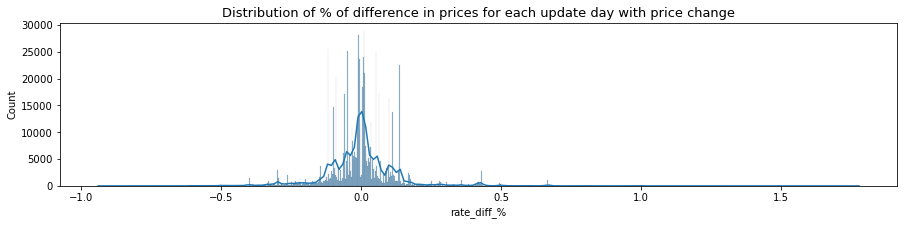

In [239]:
# Remove outlier in the 'rate_diff_%' and plot distribution of these valeus
f = plt.figure(figsize=(15,3))
f = sns.histplot(data[
    (data['rate_diff_%']!=0) & (data['rate_diff_%']<4)
                        ]['rate_diff_%'], kde=True) 
f.set_title('Distribution of % of difference in prices for each update day with price change', fontsize=13)
plt.show()

We can see that majority of price changes are centered around zero. There are some big changes in the prices to the lower values and the higher values. The biggest changes:
- to the lower values of rates - new rate is about 100% lower, 
- to the higher values of rates - new rate is about 175% higher.

### 6.3 Feature `hotel_id`

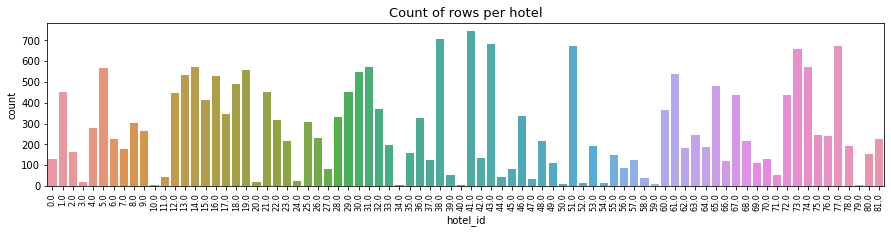

In [240]:
f = plt.figure(figsize=(15,3))
f = sns.countplot(x ='hotel_id', data = grouped)
f.set_title('Count of rows per hotel', fontsize=13)
plt.xticks(fontsize=8, rotation=90)
plt.show()

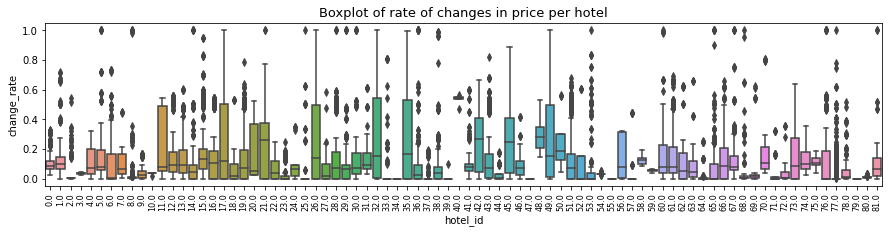

In [242]:
f = plt.figure(figsize=(15,3))
f = sns.boxplot(x='hotel_id', y='change_rate', data=grouped)
f.set_title('Boxplot of rate of changes in price per hotel', fontsize=13)
plt.xticks(fontsize=8, rotation=90)
plt.show()

The first figure shows that number of observations for different hotels varies a lot.
From the second figure we can see that some hotels seem to change rates more frequently than others. Change rate reflect average % of stay days with changed rates for each day. 

### 6.4 Feature `room_id`

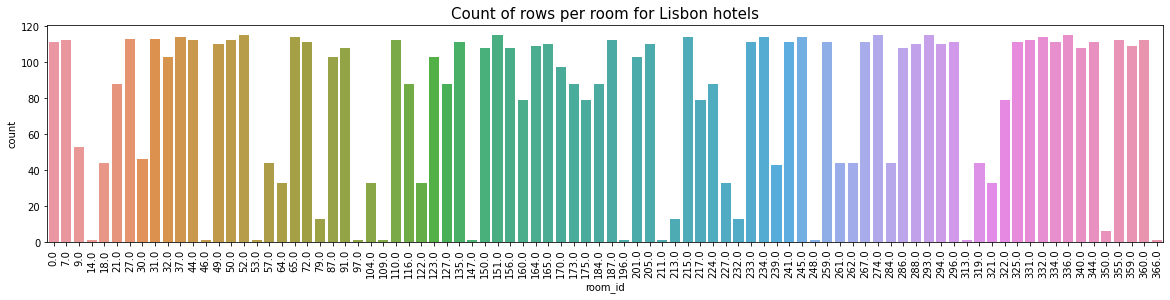

In [243]:
lisbon = grouped[grouped.hotel_city==1]

f = plt.figure(figsize=(20,4))
f = sns.countplot(x='room_id', data=lisbon)
f.set_title('Count of rows per room for Lisbon hotels', fontsize=15)
plt.xticks(fontsize=10, rotation=90)
plt.show()

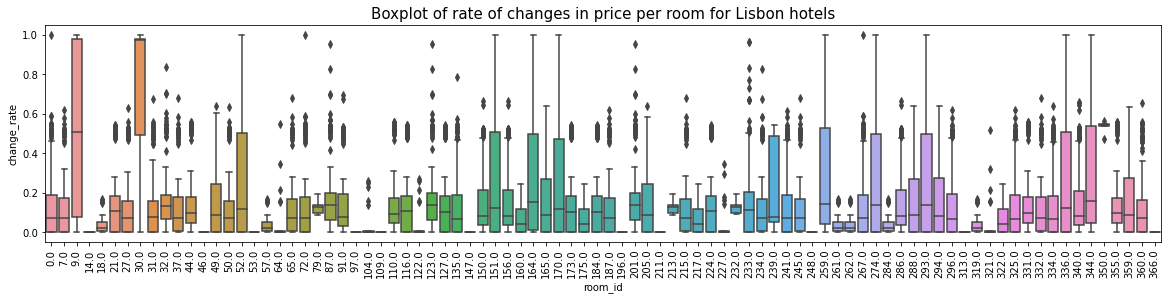

In [244]:
f = plt.figure(figsize=(20,4))
f = sns.boxplot(x='room_id', y='change_rate', data =lisbon)
f.set_title('Boxplot of rate of changes in price per room for Lisbon hotels', fontsize=15)
plt.xticks(fontsize=10, rotation=90)
plt.show()

Here we are looking at statistics for rooms in Lisbon.

The same as for the hotels - the first figure shows that number of observations for different rooms varies a lot. 

The second figure shows that for some rooms rates seem to be changed more frequently than others. For the most of the rooms change rate is not high - 75% percentile for many rooms is below 0.2 (which can be interpreted as 20% of the initial observations contain rate changes).

### 6.5 Features `update_day`, `update_numweek`  and `update_month`

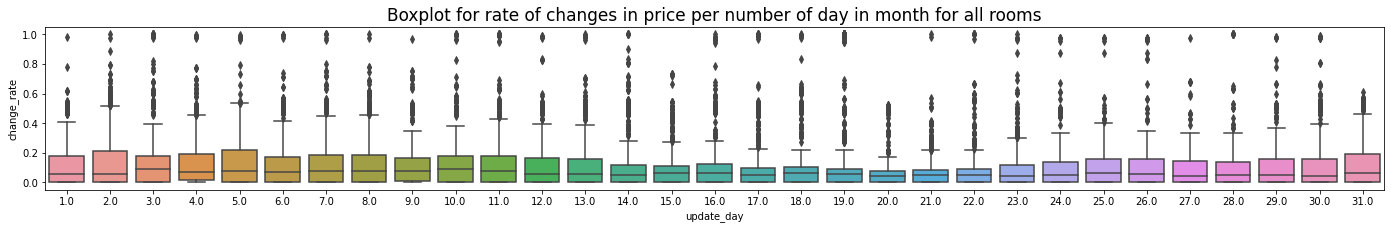

In [245]:
f = plt.figure(figsize=(24,3))
f = sns.boxplot(x='update_day', y='change_rate', data=grouped)
f.set_title('Boxplot for rate of changes in price per number of day in month for all rooms', fontsize=17)
plt.show()

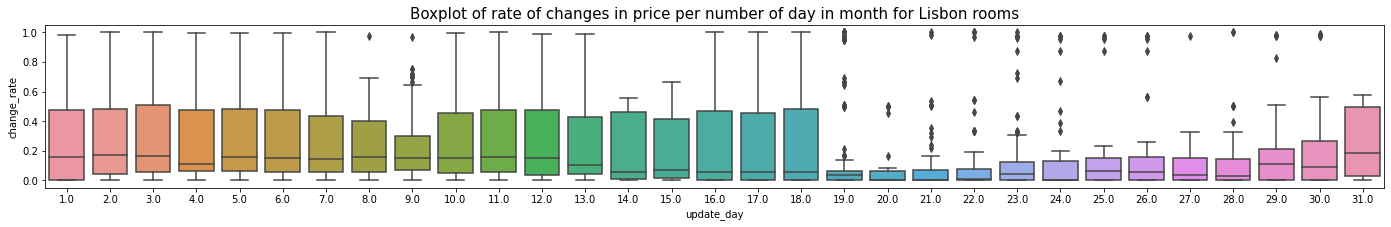

In [246]:
f = plt.figure(figsize=(24,3))
f = sns.boxplot(x='update_day', y='change_rate', data=lisbon)
f.set_title('Boxplot of rate of changes in price per number of day in month for Lisbon rooms', fontsize=15)
plt.show()

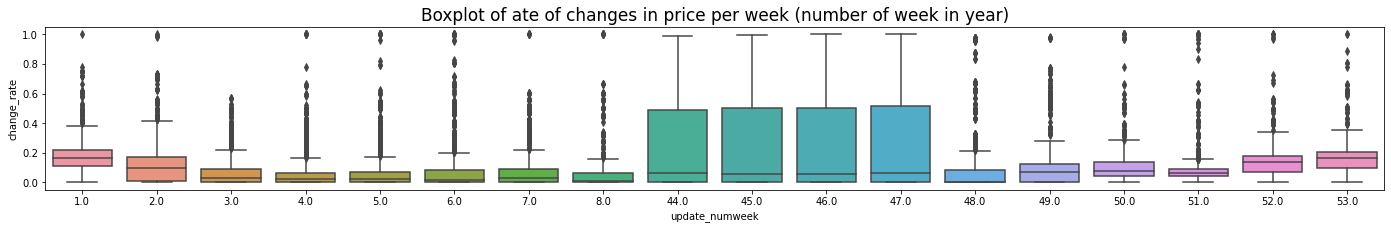

In [248]:
f = plt.figure(figsize=(24,3))
f = sns.boxplot(x='update_numweek', y= 'change_rate', data=grouped)
f.set_title('Boxplot of ate of changes in price per week (number of week in year)', fontsize=17)
plt.show()

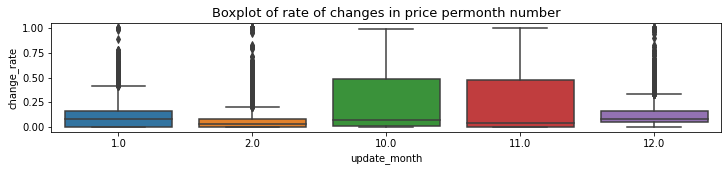

In [249]:
f = plt.figure(figsize=(12,2))
f = sns.boxplot(x='update_month', y='change_rate', data=grouped)
f.set_title('Boxplot of rate of changes in price permonth number', fontsize=13)
plt.show()

Figures show that `update_numweek` and `update_month` affect rate of changes in prices. During 2020 there were 4 weeks during which there were a lot of changes in rates. 

Interestingly, there seem to be no strong relation between % of changed prices for hotel rooms  and number of the day in month if we look at all data, but if we filter out Lisbon rooms - we will see that from 19 to 30 day of the month there seem to be much less changes in prices than for other days in month.

### 6.6 Target values (rate of changes in price) in time 

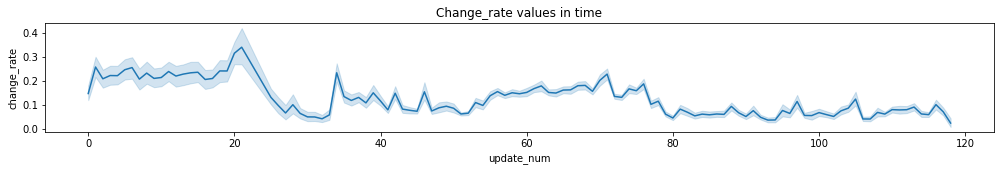

In [263]:
f = plt.figure(figsize=(17,2))
f = sns.lineplot(x='update_num', y ='change_rate', data=grouped)
f.set_title('Change_rate values in time')
plt.show()

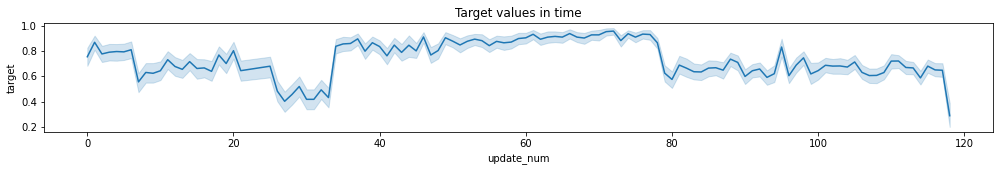

In [254]:
f = plt.figure(figsize=(17,2))
f = sns.lineplot(x='update_num', y ='target', data=grouped)
f.set_title('Target values in time')
plt.show()

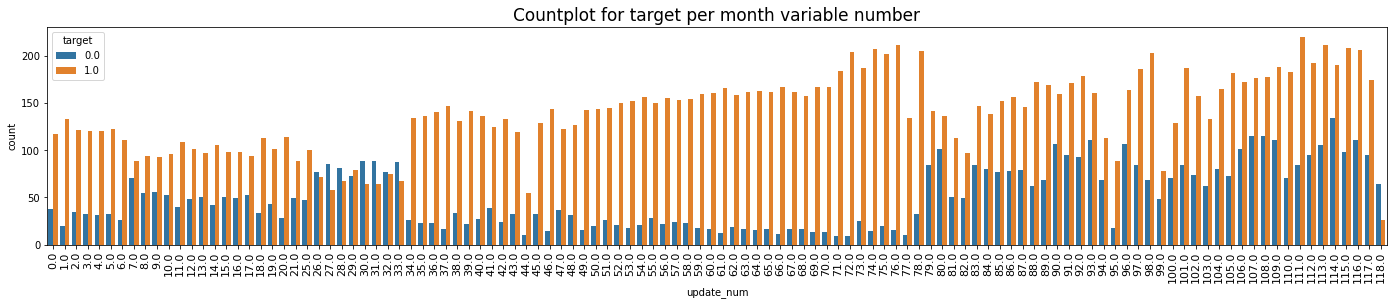

In [262]:
f = plt.figure(figsize=(24,4))
f = sns.countplot(x='update_num', hue='target', data=grouped.sort_values(by='update_numweek'))
f.set_title('Countplot for target per month variable number', fontsize=17)
plt.xticks(fontsize=11, rotation=90)
plt.show()

First chart shows dynamic of `change_rate` values for the period. We can see that approximately during first 20 days there were more changes in price and then `change_rate` drops.

The second chart shows dynamic for the target variable fro the period, we can see that during approximately days 34-77 days (weeks 44-47) values of target variable increases drastically, so during this period hotels updated prices for at least 1 stay date for almost all rooms. In the same time during these 4 weeks overall change rate did not increase much. 

### 6.7 Share of days with changed rates and distribution of  `update_stay_date_diff`

In [184]:
print('Statistics from the initial data.')
print('{0:.2f}% of all observations contain changed rates:'.format(data[data.target==1].shape[0]/data.shape[0]))
print('- {0:.2f}% for Lisbon city;'.format(data[(data.target==1)&(data.hotel_city=='Lisbon')].shape[0]/data[data.hotel_city=='Lisbon'].shape[0]))
print('- {0:.2f}% for London city;'.format(data[(data.target==1)&(data.hotel_city=='London')].shape[0]/data[data.hotel_city=='London'].shape[0]))
print('- {0:.2f}% for Barcelona city.'.format(data[(data.target==1)&(data.hotel_city=='Barcelona')].shape[0]/data[data.hotel_city=='Barcelona'].shape[0]))

Statistics from the initial data.
0.12% of all observations contain changed rates:
- 0.17% for Lisbon city;
- 0.09% for London city;
- 0.08% for Barcelona city.


In [185]:
print('Statistics from the grouped data (target is True when at least 1 rate is changed among all stay days).')
print('{0:.2f}% of all observations grouped by update day by room contain changed rates:'.format(grouped[grouped.target==1].shape[0]/grouped.shape[0]))
print('- {0:.2f}% for Lisbon city;'.format(grouped[(grouped.target==1)&(grouped.hotel_city==1)].shape[0]/grouped[grouped.hotel_city==1].shape[0]))
print('- {0:.2f}% for London city;'.format(grouped[(grouped.target==1)&(grouped.hotel_city==2)].shape[0]/grouped[grouped.hotel_city==2].shape[0]))
print('- {0:.2f}% for Barcelona city.'.format(grouped[(grouped.target==1)&(grouped.hotel_city==0)].shape[0]/grouped[grouped.hotel_city==0].shape[0]))

Statistics from the grouped data (target is True when at least 1 rate is changed among all stay days).
0.73% of all observations grouped by update day by room contain changed rates:
- 0.77% for Lisbon city;
- 0.73% for London city;
- 0.68% for Barcelona city.


Statistics from the initial data.
56.53% of the changed rates were for the closest 45 days from the update day:
- 73.54% for Lisbon city;
- 34.96% for London city;
- 51.62% for Barcelona city.


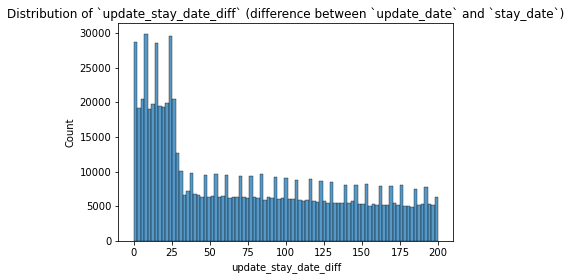

In [186]:
print('Statistics from the initial data.')
print('{0:.2f}% of the changed rates were for the closest 45 days from the update day:'
      .format(data[(data.target==1)&(data.update_stay_date_diff>45)].shape[0]/data[(data.target==1)].shape[0]*100))
print('- {0:.2f}% for Lisbon city;'
      .format(data[(data.target==1)&(data.update_stay_date_diff>45)&(data.hotel_city=='Lisbon')].shape[0]/data[(data.target==1)&(data.hotel_city=='Lisbon')].shape[0]*100))
print('- {0:.2f}% for London city;'
      .format(data[(data.target==1)&(data.update_stay_date_diff>45)&(data.hotel_city=='London')].shape[0]/data[(data.target==1)&(data.hotel_city=='London')].shape[0]*100))
print('- {0:.2f}% for Barcelona city.'
      .format(data[(data.target==1)&(data.update_stay_date_diff>45)&(data.hotel_city=='Barcelona')].shape[0]/data[(data.target==1)&(data.hotel_city=='Barcelona')].shape[0]*100))

sns.histplot(data[(data.target==1)].update_stay_date_diff)
plt.title('Distribution of `update_stay_date_diff` (difference between `update_date` and `stay_date`)')
plt.show()

## 7. Generate features of price changes history (lag features)

Frequency of rate changes from the previous periods should be useful to predict if rate will change in the future. Here we will add to each observation history of rate changes (for room and hotel) from the past periods.

In [187]:
# Drop the last day as it doesn't contain all values
grouped = grouped[grouped.update_num<118]

In [188]:
# Drop rooms with less than 14 observations per room
rooms_count = grouped.groupby('room_id').count()['hotel_id']
grouped = grouped[~grouped.room_id.isin(rooms_count[rooms_count<14])]

In [189]:
# Drop change_rate
grouped.drop(columns=['change_rate'], inplace=True)

In [190]:
# History of price changes grouped by update day and room
def generate_lag(data, lags, lag_col):
    for i in lags:
        shifted = data[['hotel_id','room_id','update_num',lag_col]].copy()
        shifted.columns = ['hotel_id','room_id','update_num', lag_col+'_lag_'+str(i)]
        shifted['update_num'] += i
        data = pd.merge(data, shifted, on=['hotel_id','room_id','update_num'], how='left')
    return data

In [191]:
# History of price changes grouped by `list_of_features_to_group`
def gen_features(list_of_features_to_group, data, new_lag_column_name, group_column, lags = [1,2,3,4,5,6,7, 14, 21]):
    group = data.groupby(list_of_features_to_group)[group_column].mean().rename(new_lag_column_name).reset_index()
    data = pd.merge(data, group, on=list_of_features_to_group, how='left')
    data = generate_lag(data, lags, new_lag_column_name)
    data.drop([new_lag_column_name], axis=1, inplace=True)
    return data

In [192]:
# Define function to generate history features
def data_proc (g = grouped, target = 'target'):    
    g.loc[:, 'target_week_avg'] = g.groupby(['room_id']).rolling(7, min_periods=1)[target].mean().shift(1).values
    g.loc[:, 'target_month_avg'] = g.groupby(['room_id']).rolling(30, min_periods=1)[target].mean().shift(1).values
    g.fillna(0.5, inplace=True)
    
    g = generate_lag(g, [7, 14, 21, 28, 35, 42], 'target_week_avg')
    g.fillna(0.5,  inplace=True)
    g = generate_lag(g, [28], 'target_month_avg')
    g.fillna(0.5,  inplace=True)
        
    # Groupby hotel_id
    g = gen_features(list_of_features_to_group=['update_num','hotel_id'], 
             data=g, new_lag_column_name ='hotel_avg_target_week',
                           group_column='target_week_avg', lags = [7, 14, 21, 28, 35, 42])
    g.fillna(0.5,  inplace=True)
    
    g = gen_features(list_of_features_to_group=['update_num','hotel_id'], 
             data=g, new_lag_column_name ='hotel_avg_target_month',
                       group_column='target_month_avg', lags = [28])
    g.fillna(0.5,  inplace=True)
    
    # Groupby 'update_numweek','hotel_id'
    g = gen_features(list_of_features_to_group=['update_numweek','hotel_id'], 
             data=g, new_lag_column_name ='hotel_avg_target_week',
                           group_column='target_week_avg', lags = [7, 14, 21, 28, 35, 42])
    g.fillna(0.5,  inplace=True)
    
    g = gen_features(list_of_features_to_group=['update_numweek','hotel_id'], 
             data=g, new_lag_column_name ='hotel_avg_target_month',
                       group_column='target_month_avg', lags = [28])
    g.fillna(0.5,  inplace=True)    
    
    g = g.astype(float)
    return g

## 8. Predict if rate changes for each day of the next week

### 8.1 Define a function for model evaluation

In [193]:
# Change dtype to int
grouped = grouped.astype({
    'hotel_id': 'int',
    'room_id': 'int',
    'hotel_city': 'int',
    'hotel_currency': 'int',
    'update_day': 'int',
    'update_month': 'int',
    'update_year': 'int',
    'update_num': 'int',
    'update_dweek': 'int'
})

In [194]:
# Separate data for each city
lisbon = grouped[grouped.hotel_city==1].copy()
lisbon.drop(columns=['hotel_city', 'hotel_currency', 'room_max_occupancy', 'min_len_of_stay'], inplace=True)
london = grouped[grouped.hotel_city==2].copy()
london.drop(columns=['hotel_city', 'hotel_currency', 'room_max_occupancy', 'min_len_of_stay'], inplace=True)
barcelona = grouped[grouped.hotel_city==0].copy()
barcelona.drop(columns=['hotel_city', 'hotel_currency', 'room_max_occupancy', 'min_len_of_stay'], inplace=True)

To evaluate model ability to predict if there is change in rates we will take the last week as test data and will try to predict the change in rates for the each day of the next week based on the data we currently have.

Below is the function to test model performance that will:
- filter out data the last 7 days to be our test set,
- change in the main dataframe target for the last 7 days to be equal to 0.5 (to avoid information leakage during features generation),
- generate history (lag) features,
- split the data to training and test sets,
- train the model and make predictions,
- print performance metrics.

In [202]:
def test_model(data, scale_pos_weight=1.2):
    recall=[]
    accuracy=[]
    precision = []
    roc_auc = []
    accuracy_train=[]

    for i in [111]:
        g = data.copy()
        test_y =  g[g.update_num>=i].target
        g.loc[g.update_num>=i, 'target'] = 0.5
    
        g = data_proc(g=g)
    
        test_x = g[g.update_num>=i].drop(columns = 'target')
        train_x = g[(g.update_num>41)&(g.update_num<i)].drop(columns = 'target')
        train_y = g[(g.update_num>41)&(g.update_num<i)].target
        train_pool = Pool(train_x, train_y)
        test_pool = Pool(test_x, test_y)
    
        clas = CatBoostClassifier(random_state = 10, silent=True, scale_pos_weight =scale_pos_weight, early_stopping_rounds=20 
                                  )
        clas.fit(train_pool, eval_set=test_pool)

        pred = clas.predict(test_x)
        recall.append(recall_score(test_y, np.array(pred, dtype=bool)))
        precision.append(precision_score(test_y, np.array(pred, dtype=bool)))
        accuracy.append(accuracy_score(test_y, np.array(pred, dtype=bool)))
        roc_auc.append(roc_auc_score(test_y, np.array(pred, dtype=bool)))
        accuracy_train.append(accuracy_score(train_y, np.array(clas.predict(train_x), dtype=bool)))
        print('Prediction for day {} is completed'.format(i))
        # Print Results 
    print('')
    print('Results of training set:')
    print("- Average overall accuracy (for both classes) on training set: {0:.2f}%".format(np.mean(accuracy_train)*100))
    print('Results on testing set:')
    print("- Average overall accuracy (for both classes): {0:.2f}%".format(np.mean(accuracy)*100))
    print("- Average recall for positive class (price changed): {0:.2f}% of rooms with changed prices were correctly identified."
          .format(np.mean(recall)*100))
    print("- Average precision for positive class (price changed): {0:.2f}% of rooms that were predicted to have changed prices actually had changes in prices."
          .format(np.mean(precision)*100))
    print("- roc_auc_score: {0:.2f}".format(np.mean(roc_auc)*100))
    print('')
    print('For the test week there were {0:.0f} observations. Model predicted that we need to update {1:.0f} rooms ({2:.2f}% of all rooms) and this way we capture {3:.2f}% of all rates changes.'
      .format(len(pred), len(pred[pred==1]), len(pred[pred==1])/len(pred)*100, np.mean(recall)*100))
    return recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x

### 8.2 Build separate models for the each city and evaluate performance 

On the EDA stage we could see from charts plotted on the initial dataset that data for Lisbon, London and Barcelona data seem to vary a lot. So here we will initialize separate models to predict rate changes for the each city.

In [203]:
# Make predictions for Lisbon rooms rate change
recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x = test_model(data=lisbon)

Prediction for day 111 is completed

Results of training set:
- Average overall accuracy (for both classes) on training set: 97.51%
Results on testing set:
- Average overall accuracy (for both classes): 88.79%
- Average recall for positive class (price changed): 84.23% of rooms with changed prices were correctly identified.
- Average precision for positive class (price changed): 94.81% of rooms that were predicted to have changed prices actually had changes in prices.
- roc_auc_score: 89.30

For the test week there were 473 observations. Model predicted that we need to update 231 rooms (48.84% of all rooms) and this way we capture 84.23% of all rates changes.


In [210]:
# Importance scores for the features. It was decided to remove features  with the smallest scores (almost zero): 
# - 'hotel_city', 'hotel_currency', 'room_max_occupancy', 'min_len_of_stay'
train_pool = Pool(train_x, train_y)
test_pool = Pool(test_x, test_y)
clas = CatBoostClassifier(random_state = 10, silent=True, scale_pos_weight =1.2)
clas.fit(train_pool, eval_set=test_pool)
print('Feature importances:')
print(pd.DataFrame(zip(train_x.columns, clas.feature_importances_), columns=['Feature', 'Importance score']).sort_values(by='Importance score', ascending=False))

Feature importances:
                            Feature  Importance score
5                        update_num         21.380612
0                          hotel_id         18.056224
13               distance_to_center         17.390935
12           hotel_total_room_count          3.560902
2                        update_day          3.424268
25   hotel_avg_target_week_lag_14_x          3.366329
24    hotel_avg_target_week_lag_7_x          2.814738
6                      update_dweek          2.683872
33   hotel_avg_target_week_lag_21_y          2.236082
31    hotel_avg_target_week_lag_7_y          2.187640
11                     hotel_rating          2.119680
32   hotel_avg_target_week_lag_14_y          1.787162
34   hotel_avg_target_week_lag_28_y          1.632426
3                      update_month          1.531978
9                          rate_old          1.511624
1                           room_id          1.502645
7                    update_weekend          1.292229
30  hot

In [205]:
# Make predictions for London rooms rate change
recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x = test_model(data=london, scale_pos_weight=1)

Prediction for day 111 is completed

Results of training set:
- Average overall accuracy (for both classes) on training set: 96.73%
Results on testing set:
- Average overall accuracy (for both classes): 90.12%
- Average recall for positive class (price changed): 93.97% of rooms with changed prices were correctly identified.
- Average precision for positive class (price changed): 93.52% of rooms that were predicted to have changed prices actually had changes in prices.
- roc_auc_score: 84.93

For the test week there were 800 observations. Model predicted that we need to update 633 rooms (79.12% of all rooms) and this way we capture 93.97% of all rates changes.


In [206]:
# Make predictions for Barcelona rooms rate change
recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x = test_model(data=barcelona)

Prediction for day 111 is completed

Results of training set:
- Average overall accuracy (for both classes) on training set: 90.89%
Results on testing set:
- Average overall accuracy (for both classes): 69.73%
- Average recall for positive class (price changed): 79.60% of rooms with changed prices were correctly identified.
- Average precision for positive class (price changed): 73.37% of rooms that were predicted to have changed prices actually had changes in prices.
- roc_auc_score: 66.81

For the test week there were 806 observations. Model predicted that we need to update 537 rooms (66.63% of all rooms) and this way we capture 79.60% of all rates changes.


Recall for the Lisbon rooms is almost 84% and for London is almost 94%. We could see during EDA that target variable values in time seemed to be quite volatile, so it's possible that there is a lot of randomness in the data.

Accuracy for Barcelona rooms is much lower, it's possible that there is not enough data for this city. Also we can see that model is clearly overfitting. 

Share of observations in the 1st class (with changed rates observations) is higher for all 3 cities, but it's especially high for the London. It means that even if we get very good results for predicting for which rooms in London rates will change - still it will be necessary to update majority of rooms. 

### 8.2 Increase weight for positive class prediction as it's important to capture all rates changes

We can improve recall for positive class by sacrificing precision of predictions.

In [207]:
recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x = test_model(data=lisbon, scale_pos_weight=2.5)

Prediction for day 111 is completed

Results of training set:
- Average overall accuracy (for both classes) on training set: 97.33%
Results on testing set:
- Average overall accuracy (for both classes): 89.85%
- Average recall for positive class (price changed): 90.77% of rooms with changed prices were correctly identified.
- Average precision for positive class (price changed): 90.77% of rooms that were predicted to have changed prices actually had changes in prices.
- roc_auc_score: 89.75

For the test week there were 473 observations. Model predicted that we need to update 260 rooms (54.97% of all rooms) and this way we capture 90.77% of all rates changes.


In [208]:
recall, accuracy, precision, roc_auc, pred, test_y, test_x, train_y, train_x = test_model(data=barcelona,  scale_pos_weight=2.5)

Prediction for day 111 is completed

Results of training set:
- Average overall accuracy (for both classes) on training set: 85.80%
Results on testing set:
- Average overall accuracy (for both classes): 73.45%
- Average recall for positive class (price changed): 98.38% of rooms with changed prices were correctly identified.
- Average precision for positive class (price changed): 70.27% of rooms that were predicted to have changed prices actually had changes in prices.
- roc_auc_score: 66.07

For the test week there were 806 observations. Model predicted that we need to update 693 rooms (85.98% of all rooms) and this way we capture 98.38% of all rates changes.


## 9. Conclusions and Recommendations

The goal of this project was to build a model to predict if at a given day there will be at least one change in rates for hotel room for 365 days ahead.

To implement the model, we grouped the data by `update_day` and `room_id`, fixed some vales in rates values and extracted features for the modeling. During the EDA we saw that there seem to be a significant difference in the patterns for rates updates for different hotels/rooms. We also could see that average values of target variable changed drastically in time.

To test the model performance, we took the last 7 days of the dataset and predicted rate change per room for the whole week ahead without updating model with the recent data. 

**The version of the model with increased weight of the positive class provided following results:**
- Lisbon rooms: 90.77% of positive class observations are predicted correctly with 90.77% precision,
- London rooms: 93.97% of positive class observations are predicted correctly with 93.52% precision,
- Barcelona rooms: 98.38% of positive class observations are predicted correctly with 70.27% precision.

**Limitations of the price prediction model:**
1. From the grouped data we can see that the share of observations with changed rates is pretty high (from 68% to 77%), so this is a limitation on how using predictive a model can reduce amount of scarping. If it's possible to achieve high accuracy of model predictions, judging from the data it will allow to reduce rate shopping iterations by 32-23% at maximum. The first steps to reduce scarping could be:
   - to perform rate shopping only 1 time per day for rooms for which changes are not expected as this day. The accuracy of predictions will be a bit higher if the model has recent data of rate changes from the previous days.
   - it's worth considering how we can to optimize rate shopping by `stay date`. For example, if for a specific city/hotel/room for specific stay days probability of rate change is 10% or less - we can skip rate shopping of this stay dates.

2. If we start to use the model to reduce the number of rate shopping iterations, it means that we will have less data for updating model and accuracy of predictions may decrease. It's important to think through strategies of keeping collecting sufficient amount of the data to update the model and keep accuracy at required level and in the same time we want to reduce number of rate updates to the optimal level. During model testing we predicted rate changes for each day for 7 days ahead, so for more distant days model didn't have recent data with rate changes history – it was done on purpose to estimate how well model can make prediction with less data.
3. As part of this project I also tested prediction of rate changes only for bookings with `stay_date` more than 45 days in the future for Lisbon rooms. Accuracy of predictions was quite low (about 65%), it seems like there is too much randomness in rates update patterns for booking for distant future `stay_date`.
4.	It’s necessary to define what are minimal requirements for the model performance and estimate if it’s feasible to achieve them.
5.	CatBoostRegressor algorithm provided the best results on the test set among several algorithms that were tested, but amount of data to be processed and the expected execution time should be taken into consideration when applying price prediction model. It's possible to test other faster algorithms if it's a critical factor.

**Possible ways to improve performance of the model:**

1. In current project feature engineering and selection was performed for Lisbon data. It's possible to explore if additional features can improve predictions for London and Barcelona data.
2. Model that was fit to Barcelona data overfits, it's worth exploring how to make this model generalize better. 
3. Explore hyperparameter tuning for CatBoostRegressor. 
4. Test other machine learning algorithms.
5. Extract more features from the data (room names, history of rate changes, mark days with announcement of changes in COVID restrictions, etc).
5. Collect more information about the hotels (for example, if a hotel belongs to a chain, etc).
3. Collect more historical data (for example, there should be seasonality in the data, so patterns of rate changes from the same season last year could be useful).